# **Automate Sentimental Analysis Of US Airline Twitter Database Using Deep Learning Algorithm**



## We follow the following steps in this model:
   

   * Packages declaration and adding our dataset
   * Data Exploration using various plots
   * Data Preparation
   * Fit a deep learning model with keras
   * Identify and deal with overfitting
   * Use word embeddings
   * Build on a pretrained model









## Package Declaration and adding our dataset

### Including Basic Packages for data prepration and modelling

In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
nltk.download('stopwords')

#Packages for data prepration
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from keras.layers import GlobalMaxPooling1D
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder

#Packages for modelling
from keras import models
from keras import layers
from keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Declaration of some variables

In [ ]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent



```
# This is formatted as code
```

### Creating menu for uploading dataset and displaying five values

In [ ]:
import io
from google.colab import files
train_tsv=files.upload()
airlines_train=pd.read_csv(io.BytesIO(train_tsv['Tweets.csv']))  
airlines_train1=airlines_train.reindex(np.random.permutation(airlines_train.index))
airlines_train1 = airlines_train[['text', 'airline_sentiment']]
airlines_train1.head()

Saving Tweets.csv to Tweets (2).csv


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### Displaying a particular instance

In [ ]:
airlines_train['text'][3]

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

## Data Exploration

### FactorPlot showing count of different sentiments

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


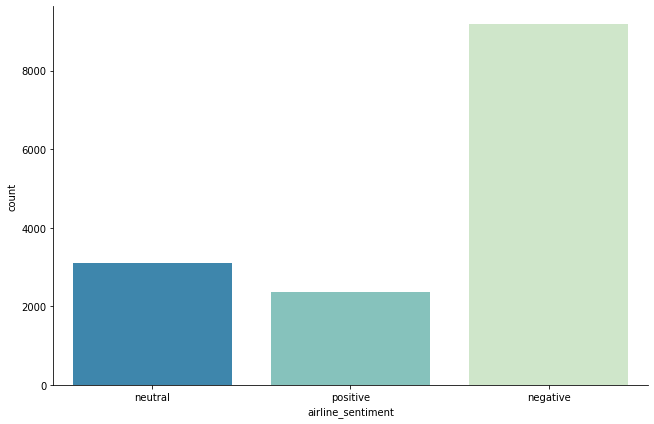

In [ ]:
sns.factorplot(x="airline_sentiment",data=airlines_train,kind="count",size=6,aspect=1.5,palette="GnBu_r")
plt.show();

### Count of different types of approach

In [ ]:
mood_count=airlines_train['airline_sentiment'].value_counts()
mood_count

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### FactorPlot showing airline wise sentiment

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


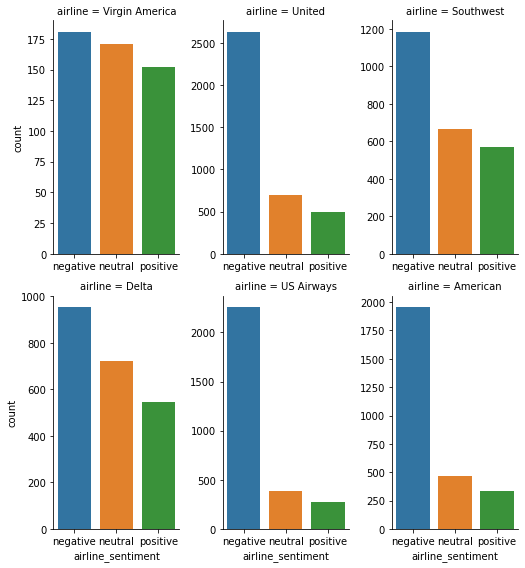

In [ ]:
sns.factorplot(x = 'airline_sentiment',data=airlines_train,
               order = ['negative','neutral','positive'],kind = 'count',col_wrap=3,col='airline',size=4,aspect=0.6,sharex=False,sharey=False)
plt.show()

### Count of negative reasons

In [ ]:
airlines_train['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

### Factorplot showing count of different negative reasons according to different airlines

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


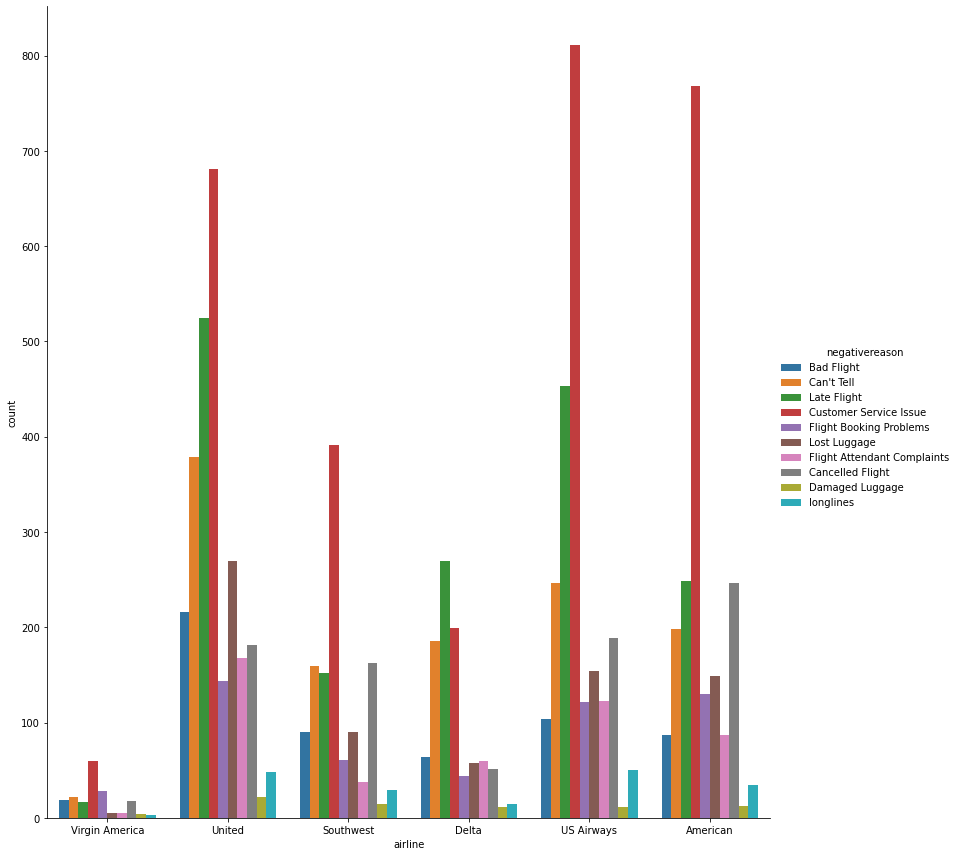

In [ ]:
sns.factorplot(x = 'airline',data = airlines_train,kind = 'count',hue='negativereason',size=12,aspect=.9)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


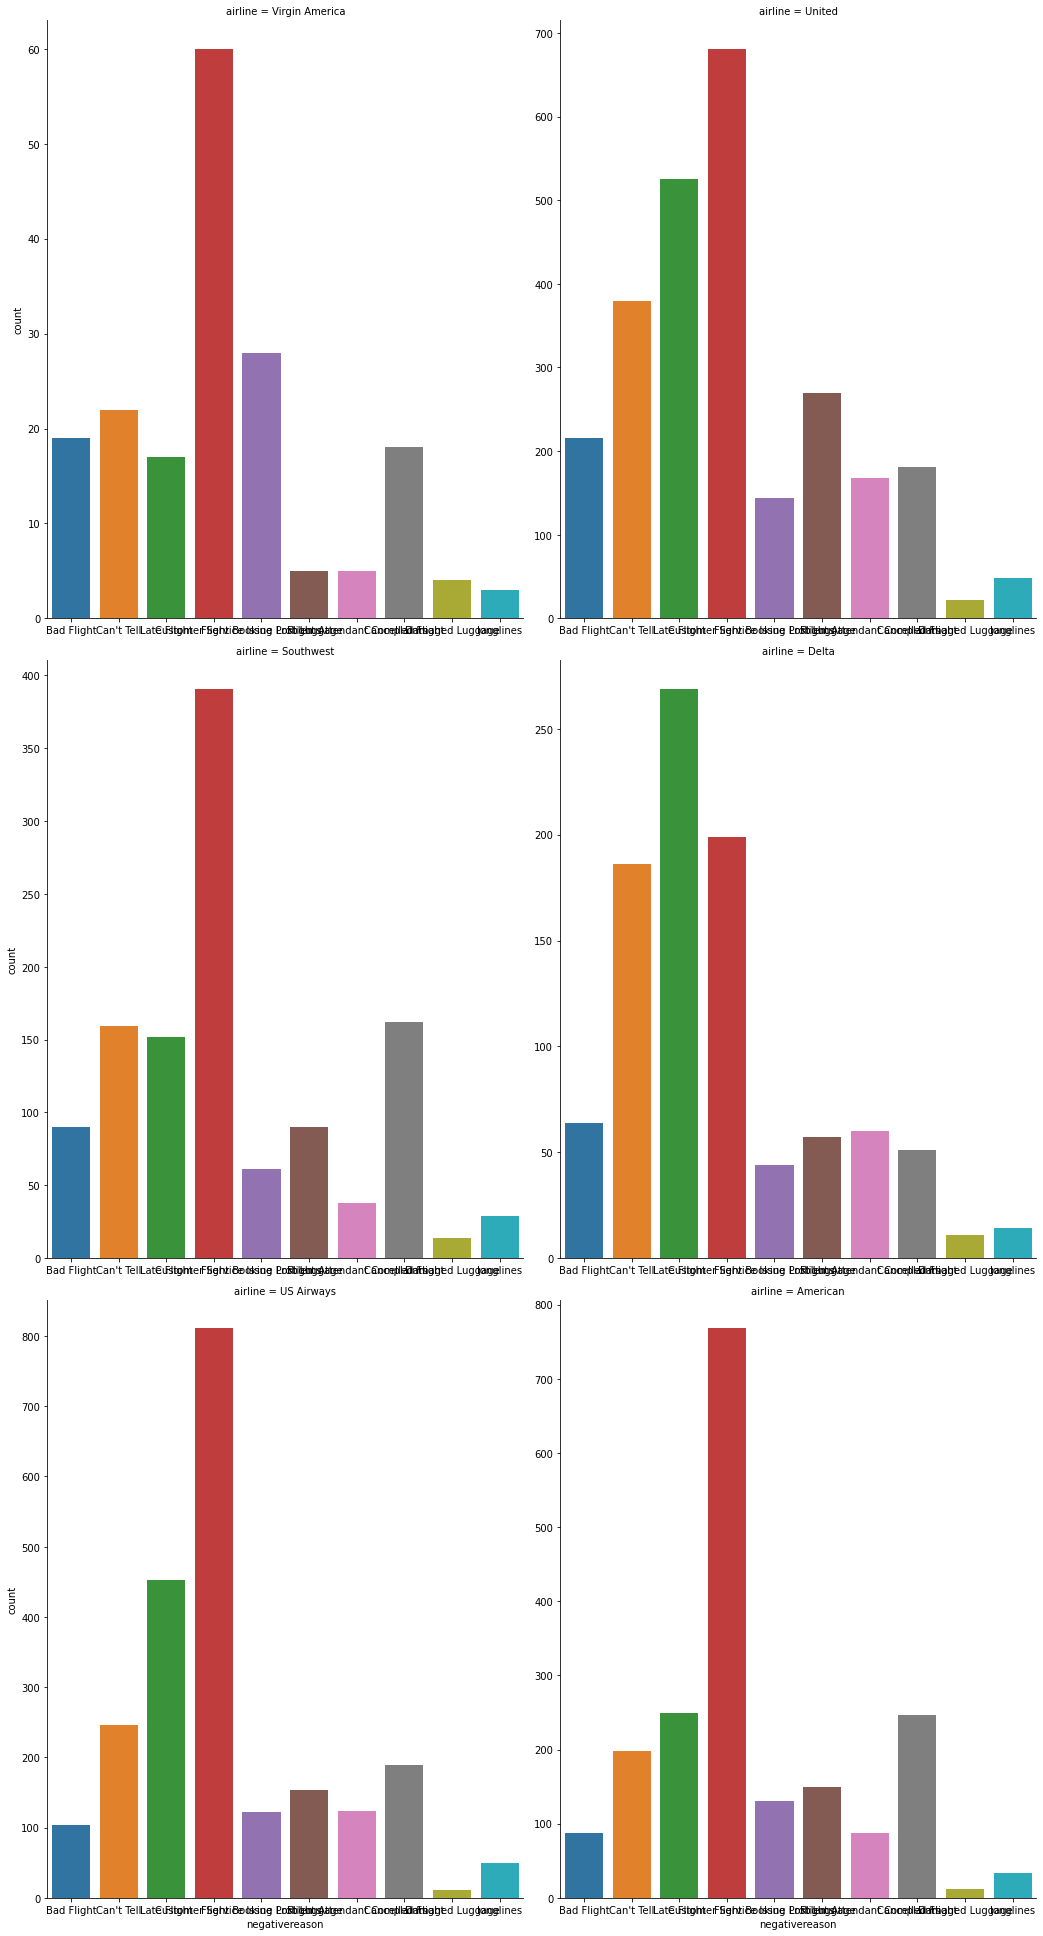

In [ ]:
sns.factorplot(x = 'negativereason',data=airlines_train,kind='count',col='airline',size=9,aspect=.8,col_wrap=2,sharex=False,sharey=False)
plt.show()

## Data Preparation
### Data Cleaning 
Removing stopwords,urls,emojis,digits by creating different functions in class CleanText.
Also Creating Functions for to_lower,fit and transform which will be used later

In [ ]:
import string
class CleanText(BaseEstimator,TransformerMixin):
  def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
  def remove_mentions(self,input_text):
        return re.sub(r'@\w+', '', input_text)
  def remove_punctuation(self,input_text):
    punct=string.punctuation
    trantab=str.maketrans(punct,len(punct)*' ')
    return input_text.translate(trantab) 
     
  def remove_urls(self,input_text):
    return re.sub(r'http.?://[^\s]+[\s]?','',input_text)
  def emoji_oneword(self,input_text):
    return input_text.replace('_','') 
  def remove_digits(self,input_text):
    return re.sub('\d+','',input_text)
  def to_lower(self,input_text):
    return input_text.lower()
  def fit(self,X,y=None,**fit_params):
    return self
  def transform(self,X,**transform_params):
    clean_X=X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits)  
    return clean_X            

### Counting records that have no word left after cleaning

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
ct=CleanText()
sr_clean=ct.fit_transform(airlines_train.text)
sr_clean.sample(5)
empty_clean=sr_clean==''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean]='[no text]'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0 records have no words left after text cleaning


In [ ]:
sr_clean[5]

' seriously would pay   a flight for seats that didn t have this playing \nit s really the only bad thing about flying VA'

## Train-Test Split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the train_test_split method of scikit-learn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sr_clean,airlines_train['airline_sentiment'] ,test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


## Converting words to number
To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying filters and putting the words to lowercase. Words are separated by spaces.

In [ ]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=False,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('to', 7725), ('I', 5683), ('the', 5208), ('a', 3952), ('you', 3557)]


 After having created the dictionary we can convert the text to a list of integer indexes. This is done with the text_to_sequences method of the Tokenizer.

In [ ]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

" What  said " is converted into [5, 785, 14, 1104, 10, 108, 45, 23, 385, 15, 19, 2276, 31, 5, 125, 1586, 15, 93, 3180, 16, 12, 4]


In [ ]:
vocab_size = len(tk.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

These integers should now be converted into a one-hot encoded features

In [ ]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[5, 785, 14, 1104, 10, 108, 45, 23, 385, 15, 19, 2276, 31, 5, 125, 1586, 15, 93, 3180, 16, 12, 4]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 20.0 features with a value of 1.


## Converting Target Class to Numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the to_categorical method in keras

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[1], y_train_le[1]))
print('"{}" is converted into {}'.format(y_train_le[1], y_train_oh[1]))

"positive" is converted into 0
"0" is converted into [1. 0. 0.]


## Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model.

In [ ]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


# Deep Learning 
## Baseline Model
We start with a model with 2 densely connected layers of 64 hidden elements. The input_shape for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The softmax activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064
In the second layer we estimate (64 x 64) + 64 = 4160 weights
In the last layer we estimate (64 x 3) + 3 = 195 weights

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use categorical_crossentropy as the loss function and softmax as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [ ]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [ ]:
base_history = deep_model(base_model)

 To evaluate the model performance, we will look at the training and validation loss and accuracy

In [ ]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

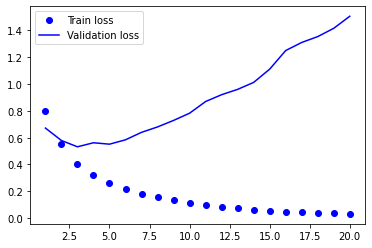

In [ ]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4.

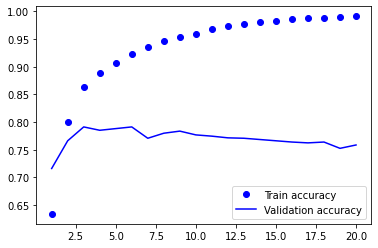

In [ ]:
eval_metric(base_history, 'accuracy')

# Handling Overfitting
Now, we can try to do something about the overfitting. There are different options to do that.

Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [ ]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduced_history = deep_model(reduced_model)

In [ ]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.



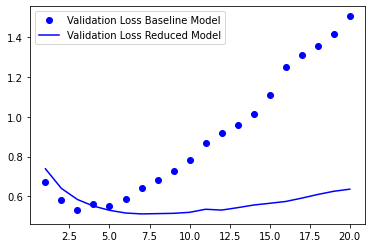

In [ ]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

## Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [ ]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

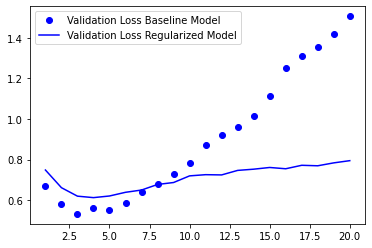

In [ ]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

## Adding dropout layers
The last option we'll try is to add dropout layers.

In [ ]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

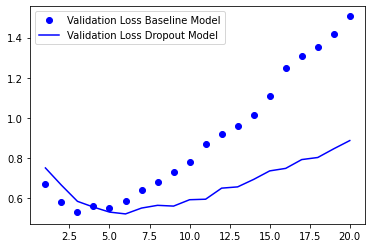

In [ ]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

## Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [ ]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [ ]:
np.random.seed()
base_results = test_model(base_model, 4)
print('/n')
d=base_results[1]*100
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

1464/1464 [==============================] - 0s 192us/step
/n
Test accuracy of baseline model: 76.16%


In [ ]:
reduced_results = test_model(reduced_model, 10)
print('/n')
a=reduced_results[1]*100
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

1464/1464 [==============================] - 0s 67us/step
/n
Test accuracy of reduced model: 78.21%


In [ ]:
reg_results = test_model(reg_model, 5)
print('/n')
b=reg_results[1]*100
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

1464/1464 [==============================] - 0s 103us/step
/n
Test accuracy of regularized model: 78.62%


In [ ]:
drop_results = test_model(drop_model, 6)
print('/n')
c=drop_results[1]*100
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

1464/1464 [==============================] - 0s 82us/step
/n
Test accuracy of dropout model: 79.30%


 hi  I just bked a cool birthday trip with you  but i can t add my elevate no  cause i entered my middle name during Flight Booking Problems 😢


# Conclusion
As we can see above, the model with the dropout layers performs the best on the test data